# CSI 6160 Homework 2
### Samantha Bracellari & Justin Kur

For this assignment, we decided to use a dataset of 1000 amazon reviews (https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences), each with a corresponding
label (0 for a negative review, 1 for a positive review). After reading the `txt` file, we process
the data and remove anything that's not a space or an alphanumeric character. After that, we make
everything lowercase, and finish by performing 5-fold cross validation and splitting the data into 
train and test sets. 80% of the data will be used for training, while the remaining 20% will be used 
for testing.

In [1]:
import polars as pl
from sklearn.model_selection import KFold

f_name = "amazon_cells_labelled.txt"

df = pl.read_csv(f_name, has_header=False, sep="\t", new_columns=["text", "label"]) # Data is tab separated
df = df.with_columns(pl.col("text").str.replace_all("[^\s\w\d]", "").str.to_lowercase()) # Strip bad characters

def fetch_data(df, use_split):
    assert(use_split >= 0 and use_split <= 4)
    # Perform 5-fold cross validation with a deterministic seed
    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    splits = list(kf.split(df.get_column("text"), df.get_column("label")))
    # Indexing the dataframe with an array returns the appropriate splits
    df_train, df_test = df[splits[use_split][0]], df[splits[use_split][1]]
    return df_train, df_test

df_train, df_test = fetch_data(df, 0)
df_train.head()

text,label
str,i64
"""so there is no...",0
"""good case exce...",1
"""great for the ...",1
"""tied to charge...",0
"""i have to jigg...",0


### Helper Functions & Global Variables

To avoid re-writing the same code multiple times, we wrote a small function that accepts a Polars
DataFrame and returns a dictionary of keyed by each distinct word in the DataFrame. The value 
corresponds to the frequency in which that word appears.

We also give the labels meaning by denoting 0 as negative and 1 as positive, and we make note of
the size of the vocabulary, where the vocabulary is essentially a set of distinct words in the entire
dataset.

In [2]:
# count the occurrence of each distinct word
def count_words(df):
    return df.select(pl.col("text").str.split(" ").alias("words").flatten()).to_series().value_counts()

VOCAB_SIZE = len(count_words(df)) # number of distinct words in the entire dataset
LABEL_TO_NAME = {0: "Negative", 1: "Positive"}

### Category Class

We wanted our implementation to be able to handle an arbitrary number of labels, so we utilized a 
class to do so. Each `Category` has a corresponding label, prior, word count, and a table of 
(word, frequency) pairs.

In [3]:
def build_categories(df_train):
    # Organize the data necessary to compute bag-of-words naive bayes classification 
    cats = {}
    for label, df in df_train.partition_by(groups="label", as_dict=True).items():
        wc = count_words(df).get_column("counts").sum()
        table = dict(count_words(df).rows()) # Contains counts of each word for the whole class
        prior = len(df) / len(df_train)
        cats[label] = Category(label, prior, wc, table)
    return cats

class Category:
    label: int
    prior: float
    word_count: int
    table: dict[str, float]
    
    def __init__(self, label, prior, word_count, table):
        self.label = label
        self.prior = prior
        self.word_count = word_count
        self.table = table 

### Visualization

We use wordclouds for the positive and negative reviews to get a sense of what words are most common
for each label, relative to one another. Any word that appeared less than 5 times was not considered
in the wordcloud. We can see the data roughly matches our expectations, with words like "excellent", "love", and "quality" being highly predictive of a good label while words like "worst", "didn't" and "junk" tend to reflect a bad review.

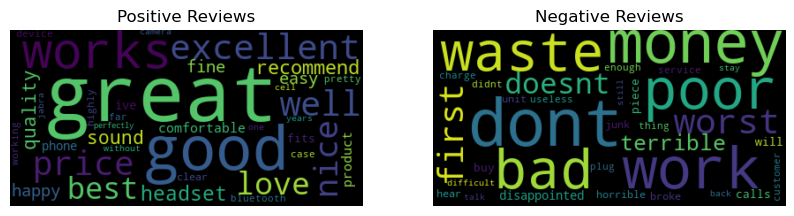

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

cats = build_categories(df)
neg, pos = cats[0], cats[1]

def cloud_prep(cat: dict[str, float], comparison: dict[str, float]):
    parsed = {}
    for key in cat.table:
        freq = cat.table.get(key, 0) - comparison.table.get(key, 0)
        if freq > 5: parsed[key] = freq
    return "".join([(key+" ")*parsed[key] for key in parsed])

pos_cloud, neg_cloud = cloud_prep(pos, neg), cloud_prep(neg, pos)

fig, axs = plt.subplots(1, 2, figsize=(10, 15))
clouds, titles = [pos_cloud, neg_cloud], ["Positive Reviews", "Negative Reviews"]

for i, (cloud, title) in enumerate(zip(clouds, titles)):
    wordcloud = WordCloud(collocations=False).generate(cloud)
    axs[i].set_title(title)
    axs[i].axis("off")
    axs[i].imshow(wordcloud, interpolation="bilinear")

### Naive Bayes from Scratch

Split the data according to its label and prepare it for Naive Bayes classification.

In [5]:
def conditional_prob(word_label_count, word_count):
    # Return the conditional probability for a single word
    return (word_count + 1) / (word_label_count + VOCAB_SIZE)

def sentence_prob(sentence: list[str], label_dict, word_label_count):
    # Compute the probability for the entire sentence 
    prob = 1.0
    for word in sentence:
        word_count = label_dict.get(word, 0)
        prob *= conditional_prob(word_label_count, word_count)
    return prob

def nb(sentence: list[str], cats):
    # Given a sentence and list of categories, predict the category with Naive Bayes
    best_cat, best = 0, -1
    for cat in cats.values():
        prob = cat.prior * sentence_prob(sentence, cat.table, cat.word_count)
        if prob > best:
            best_cat, best = cat, prob
    return best_cat.label

cats = build_categories(df_train) # Organize the data for both the positive and negative labels
LABEL_TO_NAME[nb(["best", "product", "ever"], cats)] # Show an example prediction 

'Positive'

### Accuracy Score

We do a simple accuracy check and find that our model can predict a positive or negative review 
with 79% accuracy.

In [6]:
def validation_acc(test_df, cats):
    correct = 0
    for row in test_df.rows():
        words = row[0].strip().split(" ")
        y = row[1]
        y_hat = nb(words, cats)
        if y_hat == y:
            correct += 1
    return correct / len(test_df)

print(f"{100.0 * validation_acc(df_test, cats)}% Accuracy")

79.0% Accuracy


### Benchmark Against Sci-Kit Learn

We compare against Sklearn with two goals in mind:

1. To validate our approach
2. To test whether the multi-set bag of words approach is more or less accurate than the one-hot
   approach

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing

def bench_sk(df_train, df_test):
    lb = preprocessing.MultiLabelBinarizer()
    lb.fit([sentence.split(" ") for sentence in df.get_column("text").to_list()])

    def binarize(df):
        X = lb.transform([sentence.split(" ") for sentence in df.get_column("text").to_list()])
        y = df.get_column("label").to_list()
        return X, y

    X_train, y_train = binarize(df_train)
    X_test, y_test = binarize(df_test)

    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    return mnb.score(X_test, y_test)

print(f"{100.0 * bench_sk(df_train, df_test)}% Accuracy")

78.0% Accuracy


In [8]:
our_method = []
benchmark = []
for i in range(0, 5):
    df_train, df_test = fetch_data(df, i)
    cats = build_categories(df_train)
    our_method.append(validation_acc(df_test, cats))
    benchmark.append(bench_sk(df_train, df_test))
print(f"Average Accuracy of Our Method: {100.0 * sum(our_method) / 5}%")

Average Accuracy of Our Method: 81.4%


## Cross Validation Test
We can see from the figure below that our method was superior in 3 trials, inferior in 1 trial, and equivalent in the remaining trial. However, in all cases the difference was quite small. Since we achieve similar performance to sklearn, this should validate our approach. We also see that our bag of words method is slightly superior to the one-hot encoding method, however the impact of accounting for repeat words is quite small overall. This probably because we are only classifying at the sentence-level, so content words (that would inform the sentiment of the sentence) are not often repeated. 

Naive Bayes with Bag of Words scored 81.4% accuracy overall, compared to a baseline of 50% accuracy (the classes are evenly split). This is a pretty impressive accuracy when we consider how severe the naive bayes assumption is. For instance, simple phrases like "not good" could be a challenge for this model to understand. Natural extensions would be to upgrade to a N-gram model, but this would also require a lot more data to train, so achieving much higher accuracy would probably require using pretrained data on a large corpus, e.g., word embeddings.

<AxesSubplot: title={'center': '5-Fold Cross Validation Accuracy'}, xlabel='Trial', ylabel='Accuracy'>

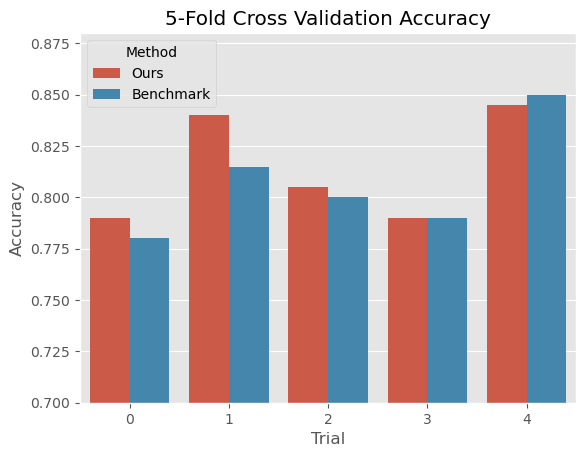

In [9]:
import seaborn
import pandas as pd 
plt.style.use('ggplot')
f, ax = plt.subplots()
method = ["Ours" for _ in range(5)] + ["Benchmark" for _ in range(5)]
plot_df = pd.DataFrame.from_dict({"Accuracy": our_method + benchmark, "Method": method, "Trial": list(range(5)) + list(range(5))})
ax.set_ylim(0.7, 0.88)
ax.set_title("5-Fold Cross Validation Accuracy")
seaborn.barplot(data=plot_df, x="Trial", y="Accuracy", hue="Method", ax=ax)